In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy

df = pandas.read_csv("forHogg.csv")

# show all available data columns
print(list(df.columns))

['id', 'fiducial', 'x', 'y', 'x2', 'y2', 'peak', 'flux', 'xWokMeasMetrology', 'yWokMeasMetrology', 'xWokMeasBOSS', 'yWokMeasBOSS', 'alphaMeas', 'betaMeas', 'xWokDitherFit', 'yWokDitherFit', 'sigmaWokDitherFit', 'configID', 'telAlt', 'telAz', 'telRot', 'FVC_SCL', 'FVC_TRAX', 'FVC_TRAY', 'FVC_ROT', 'FVC_ZB0', 'FVC_ZB1', 'FVC_ZB2', 'FVC_ZB3', 'FVC_ZB4', 'FVC_ZB5', 'FVC_ZB6', 'FVC_ZB9', 'FVC_ZB20', 'FVC_ZB27', 'FVC_ZB28', 'FVC_ZB29', 'FVC_ZB30', 'fvcImgNum', 'mjd']


Data Description
-----
Each dither measurement has a unique "configID".  Only positioners that had BOSS targets assigned during each dither are included in each configID.  Some amount of outlier rejection was performed in this data set, but nothing to careful...

id: string, unique name for each robot or fiducial

fiducial: bool, true if measurement is for a fiducial.  note, if fiducial==True then alpha/betaMeas, x/yMeasBoss x/yWokDitherFit, sigmaWokDitherFit are NaN

centroid related: (output from python 'sep' program, source extractor https://sep.readthedocs.io/en/v1.0.x/api/sep.extract.html) 

x/y: xy center of centroid on FVC CCD

x2/y2: 2nd moments of centroid on FVC CCD

peak: peak counts in centroid on FVC CCD

flux: integrated flux on FVC CCD

x/yWokMeasMetrology: fit location of metrology fiber (using distortion model fit from fiducial fibers) of the FVC centroid in the wok coordinate frame (mm).

alpha/betaMeas: calculated alpha/beta angles for each robot, inferred from x/yWokMeasMetrolgy values

x/yWokMeasBOSS: FVC calculated BOSS fiber location determined from alpha/betaMeas and (known?) relative offset from metrology to BOSS fiber

x/yWokDitherFit: Dither-calculated BOSS fiber location in wok coordinate frame.  Center of 2D gaussian psf model.  Fit from "peak up" measurements of flux in a fiber dithered near a star.

sigmaWokDitherFit (mm): best fit std for gaussian psf model (rough estimate for seeing)

configID: integer, unique to a specific robotic (dither) configuration

telAlt/Az/Rot (degrees): telescope pointing at the time of FVC imaging

FVC_SCL/TRAX/TRAY/ROT: best-fit translation/rotation/scale parameters to map FVC pixels to wok mm (no disortion included).

fvcImgNum + mjd: mjd and image number to find the raw FVC image if you want it from Utah.

Caveat
------
xyWokDitherFit locations are better when we actually dither the fiber around the star, sometimes we dither off to one side, but the fiber convolved psf fit still appears reasonable, usually, and if anything it's at least a decent guess at where the BOSS fiber actually is on the focal plane

Tour de Plots
-------------


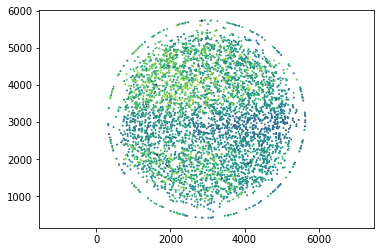

In [2]:
# plot flux as a function of CCD location for all 
# centroid measurments across all dither sequences
plt.figure()
plt.scatter(df.x,df.y,c=df.flux,s=1)
plt.axis("equal")
plt.show()

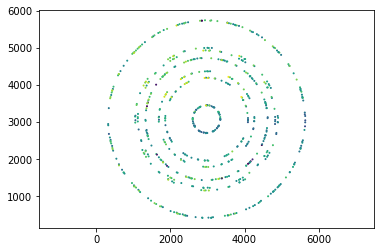

In [3]:
# plot same thing but only for fiducials
_df = df[df.fiducial==True]
plt.figure()
plt.scatter(_df.x,_df.y,c=_df.flux,s=1)
plt.axis("equal")
plt.show()

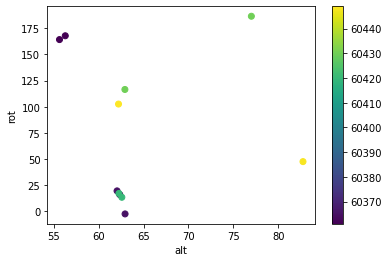

In [4]:
# plot distribution of telescope alt and rot where fvc images were taken
# color by mjd
_df = df.groupby("configID").first()
plt.figure()
plt.scatter(_df.telAlt, _df.telRot, c=_df.mjd)
plt.xlabel("alt")
plt.ylabel("rot")
plt.colorbar()
plt.show()

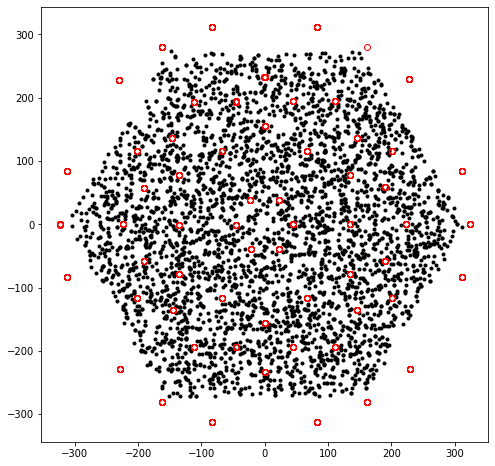

In [5]:
# plot all detections in the distortion-fit wok coordinate frame
# black spots for metrology fibers, red spots for fiducial fibers
plt.figure(figsize=(8,8))
_df = df[df.fiducial==False]
plt.plot(_df.xWokMeasMetrology, _df.yWokMeasMetrology, '.k')
_df = df[df.fiducial==True]
plt.plot(_df.xWokMeasMetrology, _df.yWokMeasMetrology, 'o', mfc="none", mec="red")
plt.axis("equal")
plt.show()

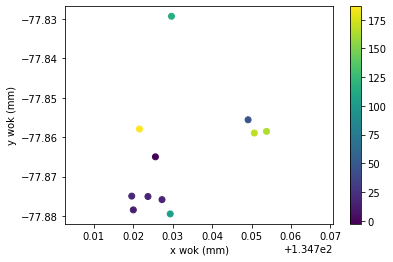

In [6]:
# visualize scatter in a single fiducial measurement across mutiple configurations
# fiducials should be fixed, so this says something about the variance 
# in the fvc mapping from pixels to wok
# color by rotator angle
_df = df[df.id=="F201781"] # a random fiducial
plt.figure()
plt.scatter(_df.xWokMeasMetrology, _df.yWokMeasMetrology, c=_df.telRot)
plt.axis("equal")
plt.xlabel("x wok (mm)")
plt.ylabel("y wok (mm)")
plt.colorbar(label="rotator angle")
plt.show()

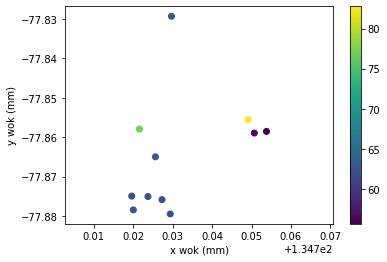

In [7]:
# visualize scatter in a single fiducial measurement across mutiple configurations
# fiducials should be fixed in the wok frame, so this says something about the variance 
# in the fvc mapping from pixels to wok
# color by telescope altitude
_df = df[df.id=="F201781"] # a random fiducial
plt.figure()
plt.scatter(_df.xWokMeasMetrology, _df.yWokMeasMetrology, c=_df.telAlt)
plt.axis("equal")
plt.xlabel("x wok (mm)")
plt.ylabel("y wok (mm)")
plt.colorbar(label="telescope alt")
plt.show()

Main Issue
----------
We want the FVC to estimate the same BOSS fiber location (using fiducials and metrology fiber spots) as the dither results.  If we do that fiber positioning should improve.

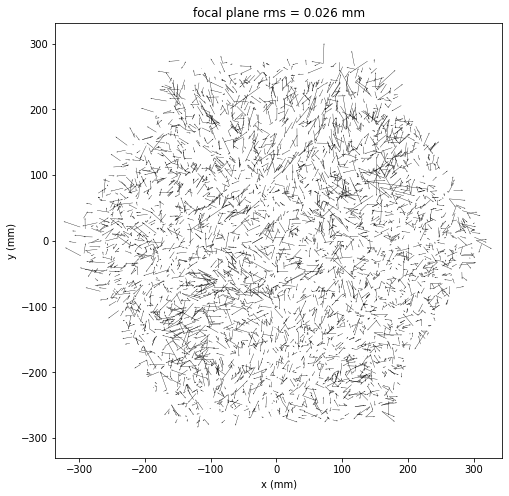

In [8]:
# plot the difference between the FVC-assumed BOSS fiber locations, and the dither-measured
# boss fiber locations
# assume that dither measurements are accurate ?
_df = df[df.fiducial==False].reset_index(drop=True)
xyDither = _df[["xWokDitherFit", "yWokDitherFit"]].to_numpy()
xyFVC = _df[["xWokMeasBOSS", "yWokMeasBOSS"]].to_numpy()
dxy = xyFVC - xyDither
rms = numpy.sqrt(numpy.mean(numpy.sum(dxy**2,axis=1)))
plt.figure(figsize=(8,8))
plt.quiver(xyDither[:,0], xyDither[:,1], dxy[:,0], dxy[:,1], angles="xy", units="xy", scale=0.002, width=0.5)
plt.axis("equal")
plt.title("focal plane rms = %.3f mm"%(rms))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()



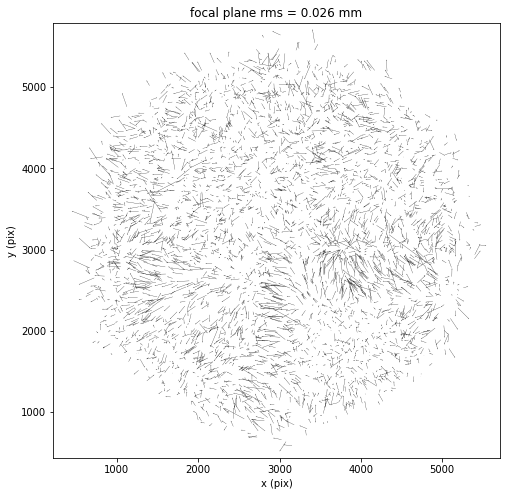

In [9]:
# rotate error vectors back into the FVC frame
fvcRotReverse = -1*numpy.radians(_df.FVC_ROT)
cosRotReverse = numpy.cos(fvcRotReverse)
sinRotReverse = numpy.sin(fvcRotReverse)
dxFVC = dxy[:,0]*cosRotReverse - dxy[:,1]*sinRotReverse
dyFVC = dxy[:,0]*sinRotReverse + dxy[:,1]*cosRotReverse
plt.figure(figsize=(8,8))
plt.quiver(_df.x, _df.y, dxFVC, dyFVC, angles="xy", units="xy", scale=0.0003, width=3)
plt.axis("equal")
plt.title("focal plane rms = %.3f mm"%(rms))
plt.xlabel("x (pix)")
plt.ylabel("y (pix)")
plt.show()

Clear spatial coherence in FVC frame (could be modeled further?).  I'm hoping that moving the FVC this summer will help...fiber imaging at the same rotator angle may also help cut down on variance, but adds overheads during field setup...

Tom Dwelly asked for visualization of overall fvc distortion correction (what are ZB's doing?)
-------------------------------------------

This is just the difference between a purely translation/rotation/scale transformation, and what the zhao-burge polynomials add on top of that when fit from the fiducial spots on the FVC CCD.  If there is no "distortion" then a similarity transform (translation/rotation/scaling) of the data will fit perfectly.  The underlying FVC code (and guider code for that matter) uses skimage.transform.SimilarityTransform in fitting this part out.  The plot below shows it's mostly radial.  RMS in the plot title below indicates the error in fiber positioning we would see if we didn't include a zhao-burge corretion based on fiducial measurements. 
    


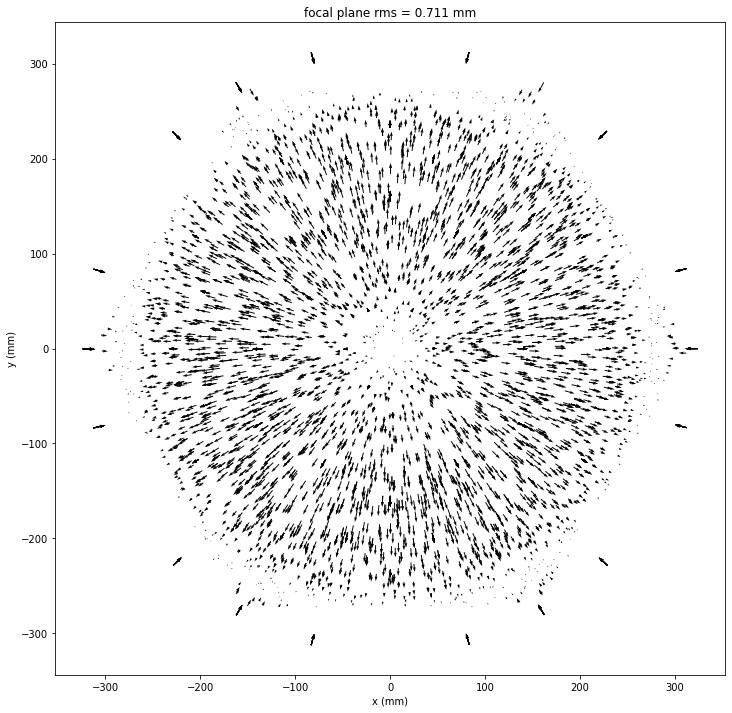

In [10]:
cosRot = numpy.cos(numpy.radians(df.FVC_ROT.to_numpy()))
sinRot = numpy.sin(numpy.radians(df.FVC_ROT.to_numpy()))
xTrans = df.FVC_TRAX.to_numpy()
yTrans = df.FVC_TRAY.to_numpy()
scale = df.FVC_SCL.to_numpy()
# apply the similairty transform to the FVC spots on the CCD to get rough wok coordinates
xWokRough = scale*(df.x*cosRot - df.y*sinRot) + xTrans
yWokRough = scale*(df.x*sinRot + df.y*cosRot) + yTrans
# difference these to see the "distortion correction"
dxDistort = xWokRough - df.xWokMeasMetrology
dyDistort = yWokRough - df.yWokMeasMetrology
rms = numpy.sqrt(numpy.mean(dxDistort**2+dyDistort**2))
plt.figure(figsize=(12,12))
plt.quiver(df.xWokMeasMetrology, df.yWokMeasMetrology, dxDistort, dyDistort, scale=0.08, width=1, angles="xy", units="xy")
plt.axis("equal")
plt.title("focal plane rms = %.3f mm"%(rms))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()


It definitely seems like the outer ring of fiducials are outside some "inflection point" on the radial distortion pattern, perhaps ignoring them or downweighting them might be useful?  In the current scheme all fiducicals carry the same weight in the fit.  Stuff warps dramatically around the edges fo the field.  Note that fiducials don't sample radially that well (see the fiducial rotation shown in the 2nd plot above), so maybe we don't expect them to.

FVC Transform Variance
---------------------
If fiducials really are fixed in the wok frame, the FVC->wok transform should predict the same location for the same fiducial over all designs and FVC images. 

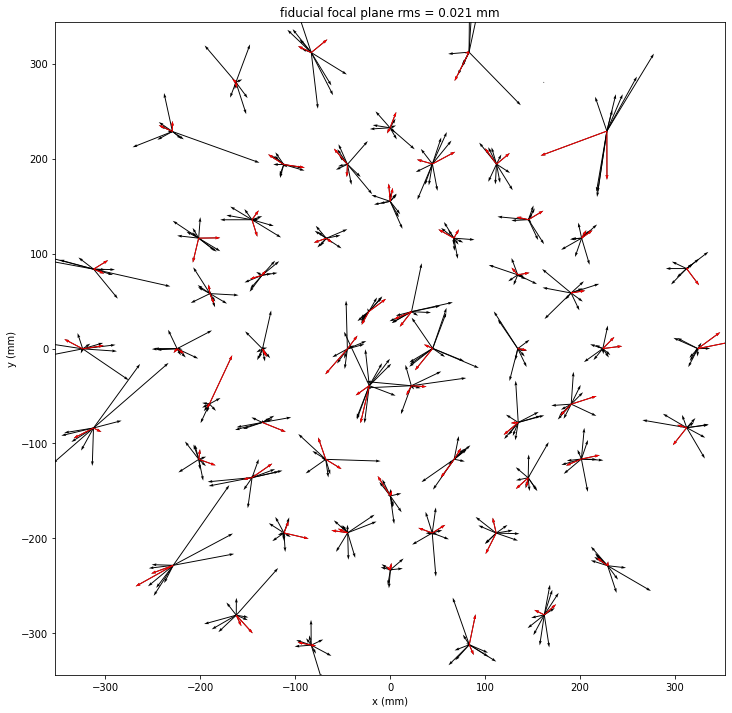

In [11]:
_df = df[df.fiducial==True]
_dfm = _df.groupby("id").mean().reset_index() # take average location for each fiducial
_df = _df.merge(_dfm, on="id", suffixes=(None, "_m"))
# mean subtract fiducial measurements
dx = _df.xWokMeasMetrology - _df.xWokMeasMetrology_m
dy = _df.yWokMeasMetrology - _df.yWokMeasMetrology_m
_df["dx"] = dx
_df["dy"] = dy
dr = numpy.sqrt(dx**2+dy**2)
rms = numpy.sqrt(numpy.mean(dr**2))

plt.figure(figsize=(12,12))
plt.quiver(_df.xWokMeasMetrology, _df.yWokMeasMetrology, _df.dx, _df.dy, scale=0.0008, width=1, angles="xy", units="xy")
plt.axis("equal")
plt.title("fiducial focal plane rms = %.3f mm"%(rms))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

# plot fiducial dxy in red for two configs with the same design that were observed back to back
# presumably measurements were made during similar telescope conditions
_df = _df[_df.configID.isin([13076,13078])]
plt.quiver(_df.xWokMeasMetrology, _df.yWokMeasMetrology, _df.dx, _df.dy, scale=0.0008, width=1, color="red", angles="xy", units="xy")

plt.show()


Zhao-Burge distortion visualizations
---------------------


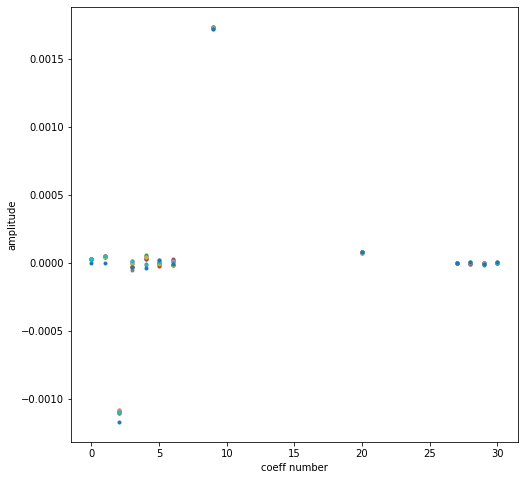

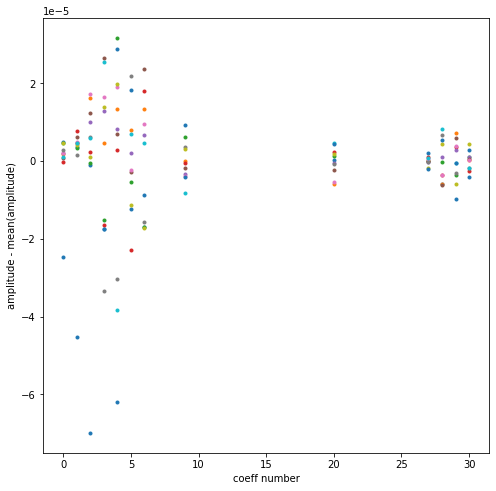

In [27]:
POLIDS = numpy.array([0, 1, 2, 3, 4, 5, 6, 9, 20, 27, 28, 29, 30])
RMAX = 310 # scale factor chosen to put xyWok roughly on unit circle (note outer fiducials land a little outside this)
# plot all coeffs for all fvc measurements
_df = df.groupby("configID").first().reset_index()
plt.figure(figsize=(8,8))
amps = []
for idx, row in _df.iterrows():
    _amps = []
    for pid in POLIDS:
        _amps.append(row["FVC_ZB%i"%pid])
    plt.plot(POLIDS, _amps, '.', label=row["configID"])
    amps.append(_amps)
# plt.legend(title="configID")
plt.ylabel("amplitude")
plt.xlabel("coeff number")
plt.show()

amps = numpy.array(amps)
amps_m = numpy.mean(amps,axis=0)
d_amps = amps - amps_m

plt.figure(figsize=(8,8))
for cfg in d_amps:
    plt.plot(POLIDS, cfg, '.')
plt.ylabel("amplitude - mean(amplitude)")
plt.xlabel("coeff number")
plt.show()




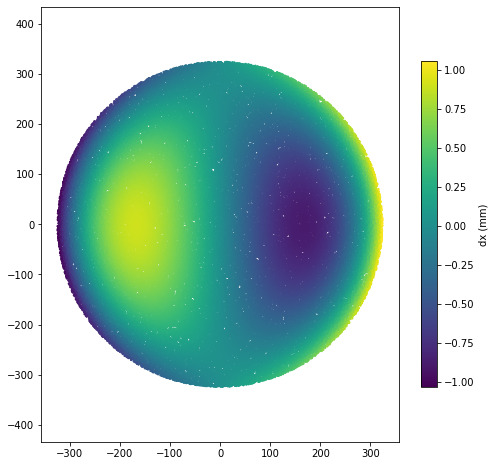

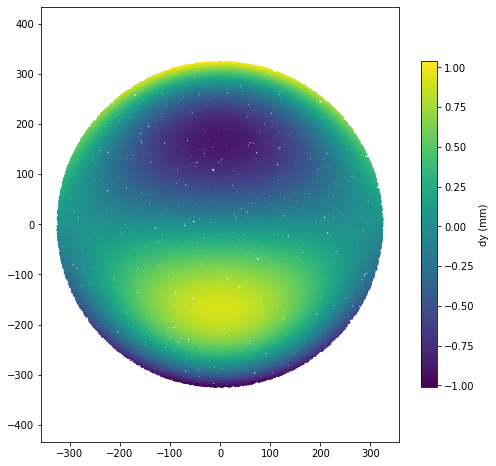

In [56]:
# find centroid at largest measured radius (will be one of the edge fiducials)
from zhaoburge import getZhaoBurgeXY
rmax = int(numpy.max(numpy.sqrt(df.xWokMeasMetrology**2+df.yWokMeasMetrology**2)))
nSamples = 100000

rs = numpy.sqrt(numpy.random.uniform(size=nSamples))*rmax
thetas = numpy.random.uniform(size=nSamples)*2*numpy.pi
xs = rs*numpy.cos(thetas)
ys = rs*numpy.sin(thetas)

# apply the "average" zb coeffs on our random samples

dx,dy = getZhaoBurgeXY(POLIDS, amps_m, xs, ys, normFactor=RMAX)

plt.figure(figsize=(8,8))
plt.scatter(xs,ys,c=dx,s=2)
plt.colorbar(label="dx (mm)", shrink=0.75)
plt.axis("equal")
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(xs,ys,c=dy,s=2)
plt.colorbar(label="dy (mm)", shrink=0.75)
plt.axis("equal")
plt.show()


